## Results of Host Prediction
### Dataset: EMBL mapping, Vertebrates, Non-IDV

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 5

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
import seaborn

In [2]:
import sys
import os
from scipy.stats import mannwhitneyu, wilcoxon, ranksums
from statannotations.Annotator import Annotator
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../..']

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import mannwhitneyu
from src.utils import visualization_utils
from statannotations.Annotator import Annotator

In [4]:
sns.__version__

'0.13.0'

In [5]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}




In [7]:
# df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/evaluation/uniref90/20240517/host_multi_all_models/host_multi_all_models_evaluation_metrics.csv"))
# df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/evaluation/uniref90/20240611/host_multi_all_models/host_multi_all_models-msl2048_evaluation_metrics.csv"))
#df = pd.read_csv(os.path.join(os.getcwd(), "..",  "..", "..", "..", "output/evaluation/uniref90/20241106/host_multi/host_multi_all_models_evaluation_metrics.csv"))
# df = pd.read_csv(os.path.join(os.getcwd(), "..",  "..", "..", "..", "output/evaluation/uniref90/20241127/host_multi/host_multi_all_models_evaluation_metrics.csv"))
df = pd.read_csv(os.path.join(os.getcwd(), "..",  "..", "..", "..", "output/evaluation/uniref90/20241202/host_multi/host_multi_all_models_evaluation_metrics.csv"))
df.drop(columns="Unnamed: 0", inplace=True)
df

,itr,experiment,auprc
0,0,LR,0.433765
1,1,LR,0.428972
2,2,LR,0.440230
3,3,LR,0.464170
4,4,LR,0.437962
...,...,...,...
60,0,VirProBERT,0.639349
61,1,VirProBERT,0.672554
62,2,VirProBERT,0.703604
63,3,VirProBERT,0.688975


In [8]:
df = df.replace({"experiment": {"LR-maxitr5000": "LR", "Protein-BERT": "ProteinBERT", "VirPro-BERT": "VirProBERT", "Protein-BERT_new_ds": "ProteinBERT"}})

In [9]:
df["experiment"].unique()

array(['LR', 'RF', 'SVM', 'FNN', 'CNN', 'RNN', 'LSTM',
       'Transformer-Encoder', 'ProstT5-lr1e-4', 'ProstT5-lr3e-4',
       'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT'], dtype=object)

In [10]:
sub_df = df[df["experiment"].isin(["LR", "RF", "SVM", "CNN", "RNN", "LSTM", "ProstT5-lr3e-4", "ESM2-t33_650M_UR50D", "ESM3", "VirProBERT"])]
sub_df = sub_df.replace({"experiment": {"Hybd-sl256st64-CLS-vs30-AE-BN": "VirProBERT"}})

In [11]:
sub_df["experiment"].unique()

array(['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4',
       'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT'], dtype=object)

In [26]:
experiments = ['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']
pairs = [#("ProteinBERT", "VirProBERT"),
         #("VirProBERT", "Transformer-Encoder"), 
         ("VirProBERT", "ESM3"), 
         ("ESM2-t33_650M_UR50D", "VirProBERT"), 
         ("VirProBERT", "ProstT5-lr3e-4"), 
         ("VirProBERT", "LSTM"),
         ("VirProBERT", "RNN"),
         ("VirProBERT", "CNN")]

def get_p_value_annotation(p_value):
    if p_value > 5e-2 and p_value <= 1:
        return "ns"
    elif p_value > 1e-2 and p_value <= 5e-2:
        return "*"
    elif p_value > 1e-3 and p_value <= 1e-2:
        return "**"
    elif p_value > 1e-4 and p_value <= 1e-3:
        return "***"
    elif p_value <= 1e-4:
        return "****"
    else:
        return None
    
def plot_boxplot_w_stat_custom_annotation(df, metric, pairs, location, ylim):
    DEFAULT_FIGURE_CONFIG = {
        "figsize": (16, 8),
        "xtick.labelsize": 18,
        "ytick.labelsize": 18
    }
    color_palette = sns.cubehelix_palette(start=3, rot=4.5, hue=1, gamma=0.9, dark=0.7, light=0.4, reverse=True, n_colors=df["experiment"].nunique())
    plotting_parameters = {
        'data':    df,
        'x':       'experiment',
        'y':       metric,
        "linewidth": 2,
        #"edgecolor": "black",
        "linecolor": "black",
#         "boxprops": {"edgecolor": "black"},
#         "whiskerprops": {"color": "black"},
#         "flierprops": {"color": "black"},
#         "fliersize": 7.0,
#         "medianprops": {"linewidth": 2.5},
        'palette': color_palette#sns.color_palette("magma", n_colors=len(experiments)),
        #"notch": True,
        #"fill": False
    }
    
    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    ax = sns.boxplot(**plotting_parameters, order=experiments)
    sns.stripplot(data=df, x="experiment", y=metric, ax=ax, color="black", size=8, alpha=.7, order=experiments)
    ax.set_xlabel("", size=1, labelpad=5)
    ax.set_ylabel(metric.upper(), size=20)
    plt.draw()
    ax.set_ylim(*ylim)
    
    #plt.tight_layout()
    
    for i, pair in enumerate(pairs):
        model_1_values = df[df["experiment"] == pair[0]][metric].values
        model_2_values = df[df["experiment"] == pair[1]][metric].values
        p_value = mannwhitneyu(model_1_values, model_2_values, alternative="greater").pvalue
        formatted_pvalue = f"p={p_value:.2e}"
        print(f"{pair}: p-value={formatted_pvalue}")
        
        x_ticks = [t.get_text()  for t in ax.get_xticklabels()]
        print(x_ticks)
        x1 = experiments.index(pair[0])
        x2 = experiments.index(pair[1])
        y1 = max(df[df["experiment"] == pair[0]][metric].max(), 
                 df[df["experiment"] == pair[1]][metric].max()) + (0.05 * (i + 1))
        y2 = y1 + .01
        
        plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=1.5, c="k")
        plt.text((x1 + x2)*.5, y1, get_p_value_annotation(p_value), ha='center', va='bottom', color="k", size="18")
    visualization_utils.wrap_ticklabels(ax, axis="x", label_width=10, break_long_words=True)
    plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_all_models_{metric}_boxplot_stat.pdf"), bbox_inches="tight")

('VirProBERT', 'ESM3'): p-value=p=2.65e-01
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']
('ESM2-t33_650M_UR50D', 'VirProBERT'): p-value=p=6.09e-03
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']
('VirProBERT', 'ProstT5-lr3e-4'): p-value=p=6.09e-03
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']
('VirProBERT', 'LSTM'): p-value=p=6.09e-03
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']
('VirProBERT', 'RNN'): p-value=p=6.09e-03
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']
('VirProBERT', 'CNN'): p-value=p=6.09e-03
['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProstT5-lr3e-4', 'ESM2-t33_650M_UR50D', 'ESM3', 'VirProBERT']


/tmp/ipykernel_3538664/3401532643.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(**plotting_parameters, order=experiments)
/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../src/utils/visualization_utils.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0)


<Figure size 432x288 with 0 Axes>

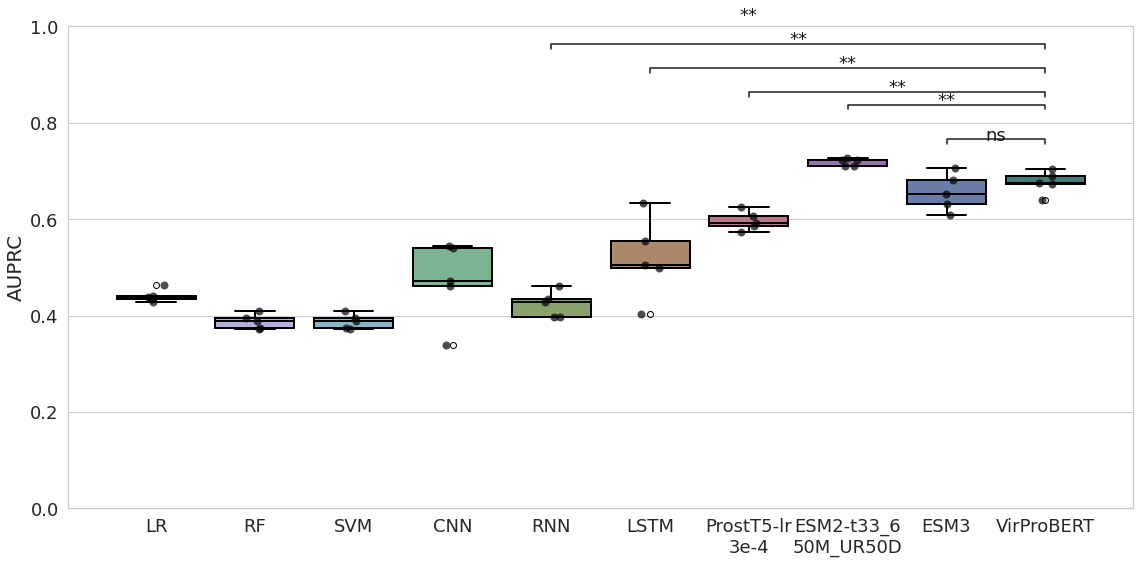

In [27]:
plot_boxplot_w_stat_custom_annotation(sub_df, "auprc", pairs, location="inside", ylim=(0, 1))